## <center> Processing tree-like data to be represented as a Plotly Sunburst</center>

Sunburst is a chart type to plot hierarchical data with a rooted tree structure.  It can be seen as  a radial treemap or a multi-level pie chart, because it consists in a central disk representing the tree root, and a sequence of nested rings, divided in sectors, that represent the tree nodes. Each ring corresponds to a particular level in the tree.

The size and color of sectors represent node attributes.  By default Plotly assigns the white color to the root and
 distinct color to each  
subtree starting from the level 1 nodes. From now on we call  such subtrees, *level 1 subtrees*. 

The basic information needed to plot a sunburst, via Plotly, is the list of node ids, the list of their labels,
and the list of corresponding parent ids.  In the list of parent ids the root  parent is represented by `''`.

For trees with a reduced number of nodes these lists can be derived manually. The aim of this notebook is to show how we can get these lists
when the tree data are read from a `json` file, `csv` file or a `gml` file.

### Sunburst from a tree structure read from a json file

We are illustrating how the  Python functions to be defined below act on json data, interpreted as being the following  dict:

In [1]:
tree = {'name':0,
        'children':[{'name':1,
                     'children': [{'name':3, 
                                   'children':[{'name': 7,
                                                'children': [{'name': 17}]},
                                               {'name':8}, 
                                               {'name':9}]},
                                  {'name': 4,
                                   'children': [{'name':10},
                                                {'name':11}]}]
                    },
                    {'name':2,
                     'children': [{'name':5, 
                                   'children':[{'name': 12}, 
                                               {'name':13, 'children': [{'name': 18}]}, 
                                               {'name':14}]},
                                  {'name': 6,
                                   'children': [{'name':15},
                                                {'name':16}]}]
                    }
                 ]}


that represents the tree displayed in the second cell:

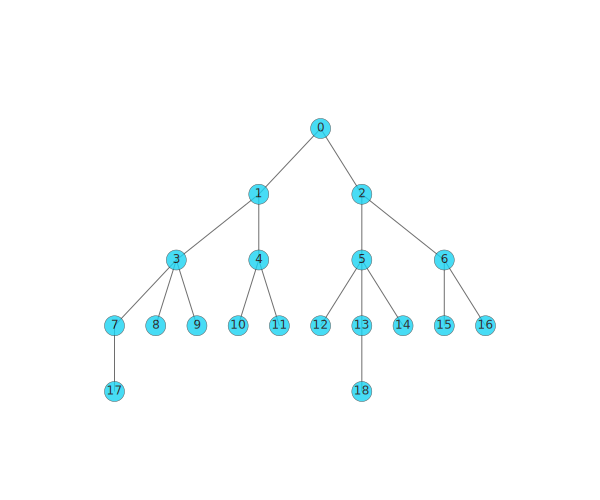

In [2]:
from IPython.display import SVG, display
SVG(filename='mytree.svg')

Depending on what information we want to highlight with the sunburst representation of tree data, we perform either the
preorder tree traversal or the level by level traversal, to get the lists of node labels and of their parents.

 The  function defined below extracts  from a json  data
the list of  node labels
and the list of corresponding parents,  following the preorder method to traverse a tree:

In [3]:
def preorder_label_parent(tree_dict, labels=None, parents=None):
    if labels is None:
        labels=list()
    if parents is None:
        parents=[''] 
    labels.append(tree_dict['name'])
    last_node=tree_dict['name']
    if 'children' in tree_dict:
        for child in tree_dict.get('children'):
            parents.append(last_node)
            preorder_label_parent(child, labels, parents)
        
    return labels, parents

In [4]:
pre_labels, pre_parents = preorder_label_parent(tree)
list(zip(pre_labels, pre_parents))

[(0, ''),
 (1, 0),
 (3, 1),
 (7, 3),
 (17, 7),
 (8, 3),
 (9, 3),
 (4, 1),
 (10, 4),
 (11, 4),
 (2, 0),
 (5, 2),
 (12, 5),
 (13, 5),
 (18, 13),
 (14, 5),
 (6, 2),
 (15, 6),
 (16, 6)]

  The function  `level_parent_label()`
extracts the label, parent lists in the level order:

In [7]:
from collections import deque  # https://docs.python.org/3/library/collections.html#collections.deque
   
def level_parent_label(json_data,  labels=None, parents=None):
    
    if labels is None:
        labels = list()
    if parents is None:
        parents = ['']
    to_traverse = deque([json_data])
    
    while len(to_traverse) > 0:
        subtree = to_traverse.popleft()
        #print('\n', subtree)  # uncomment this line to see the contents of the dict subtree
        if 'name' in subtree:
            labels.append(subtree['name']) # subtree['name'] is the name of the subtree root
            parent = subtree['name']
            if 'children' in subtree:
                for child in subtree['children']:
                    parents.append(parent)
                to_traverse.extend(subtree['children'])
    return  labels, parents         

In [8]:
level_labels, level_parents = level_parent_label(tree)
list(zip(level_labels, level_parents))

[(0, ''),
 (1, 0),
 (2, 0),
 (3, 1),
 (4, 1),
 (5, 2),
 (6, 2),
 (7, 3),
 (8, 3),
 (9, 3),
 (10, 4),
 (11, 4),
 (12, 5),
 (13, 5),
 (14, 5),
 (15, 6),
 (16, 6),
 (17, 7),
 (18, 13)]

 Starting with  the lists of node labels and their parents, the next function
assigns an id to each node and
maps each parent to the corresponding id to get the list of parent ids:

In [9]:
def get_ids(labels, parents):
    if len(labels) !=  len(parents):
        raise ValueError('The list of labels should have the same length like the list of parents')
    N = len(labels)
    ids =[str(id)   for id in range(N)]
    dlabels = {label: idx  for label, idx in zip(labels, ids)} # associate to each label the corresponding id
    parentids =[''] + [dlabels[label] for label in parents[1:]] 
    return ids, parentids

**1. The sunburst representation of the tree recorded in the  classical `flare.json` file**

In [10]:
import requests, json
import plotly.graph_objs as go
from chart_studio.plotly import  iplot

In [11]:
url1 ='https://raw.githubusercontent.com/d3/d3-hierarchy/master/test/data/flare.json'
content = requests.get(url1)
flare_data = json.loads(content.content)
labels, parents = preorder_label_parent(flare_data)

Now let us associate ids to tree nodes, and derive the parent ids, too:

In [12]:
ids, parentids = get_ids(labels, parents)

In [13]:
len(labels), len(ids), len(parentids)

(252, 252, 252)

In [14]:
flare_trace = go.Sunburst(ids=ids,
                          labels=labels,
                          parents=parentids)

Since no `marker.color` is set, this sunburst will be colored with the colorway defined for the 'plotly' template.

In [15]:
layout = go.Layout(title=dict(text='Flare sunburst', x=0.5),
                   font= dict(size=12),
                   showlegend=False,
                   autosize=False,
                   height=750,
                   xaxis=dict(visible=False),
                   yaxis=dict(visible=False),          
                   hovermode='closest'
                  )

In [17]:
fig1 = go.Figure(data=[flare_trace], layout=layout)
#fig1.show()

In [18]:
iplot(fig1, filename='flare-sunburst')

If  layout.template='none', then the level 1 subtrees are colormapped to colors  
 derived from the `DEFAULT_PLOTLY_COLORS`:
 
 ```
DEFAULT_PLOTLY_COLORS = [
    "rgb(31, 119, 180)",
    "rgb(255, 127, 14)",
    "rgb(44, 160, 44)",
    "rgb(214, 39, 40)",
    "rgb(148, 103, 189)",
    "rgb(140, 86, 75)",
    "rgb(227, 119, 194)",
    "rgb(127, 127, 127)",
    "rgb(188, 189, 34)",
    "rgb(23, 190, 207)",
] ```
 
displayed  below:

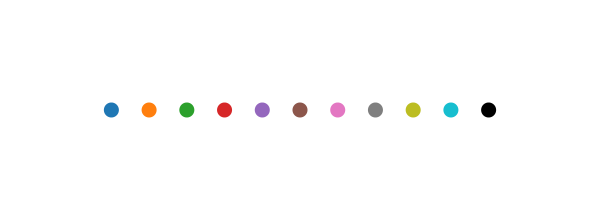

In [19]:
SVG(filename='pl-default-colors.svg')                        

For any plotly template the level 1 subtrees are colormapped to colors derived from colorway:

In [20]:
colorway = ['#636efa', '#EF553B', '#00cc96', '#ab63fa', '#FFA15A', '#19d3f3', '#FF6692', '#B6E880', '#FF97FF', '#FECB52']

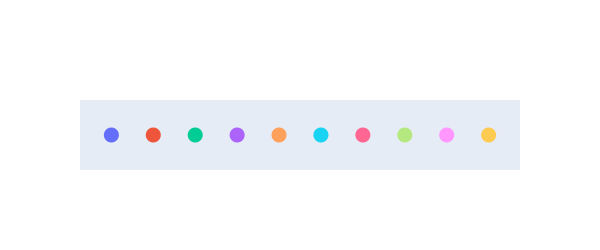

In [21]:
SVG(filename='template-colorway.svg')                        

For more information on how the colors for the sunburst sectors  are derived from a list of colors, called `sunburstcolorway`, see [https://plot.ly/python/reference/#sunburst](https://plot.ly/python/reference/#sunburst), and [https://plot.ly/python/reference/#layout-sunburstcolorway](https://plot.ly/python/reference/#layout-sunburstcolorway).

**2.   Sunburst defined by data read from a json file in the  level order, and plotted with custom colors**

In [22]:
url2 = 'https://raw.githubusercontent.com/busterbenson/public/master/cognitive-bias-cheat-sheet.json'
content = requests.get(url2)
bias_data = json.loads(content.content)

Let us  extract the sunburst data in level order:

In [23]:
labels, parents = level_parent_label(bias_data)
ids, parentids = get_ids(labels, parents)

Display the number of level 1 nodes (subtrees) from `bias_data`:

In [24]:
len(bias_data['children'])

4

Hence to assign  a custom color to each level 1 subtree we define 5 hexcolors: the first one for the root and the following four for  the level 1 subtrees:

In [25]:
colors = ['#ffffff',# color for root
          '#854277',# the next four colors are assigned to the four subtrees starting from the level 1 nodes
          '#c44a9a',
          '#c9d1de',  
          '#709fdc']

In [26]:
cog_bias = go.Sunburst(ids=ids,
                       labels=labels,
                       parents=parentids,
                       marker=dict(colors=colors,
                                   line=dict(width=1.5
                                            )))

In [27]:
fig2 = go.FigureWidget(data=[cog_bias], layout=layout)
fig2.layout.update(title= dict(text='Sunburst with custom colors', x=0.5),
                   height=800);

In [29]:
iplot(fig2, filename='bias-sunburst')

## Sunburst defined from tree data recorded in a csv file 

When hierarchical data having a rooted tree structure is stored in a csv file, we first have to associate a tree-dict to the 
dataframe read from that file, and then to derive the lists defining a sunburst, as in the above cases. 

We note that we are discussing a case when the csv file hasn't as columns the ids, labels and parents, like in the 
files read here [https://plot.ly/python/sunburst-charts/](https://plot.ly/python/sunburst-charts/).

Read the csv file containing a dataframe that stores on its columns information on the someone portfolio.  Sunburst representation of data
illustrates the asset categories and classes.

In [30]:
import pandas as pd

In [31]:
url3 = 'https://raw.githubusercontent.com/gluc/useR15/master/00_data/portfolio.csv'
df = pd.read_csv(url3)
df.head()

,ISIN,Name,Ccy,Type,Duration,Weight,AssetCategory,AssetClass,SubAssetClass
0,LI0015327682,LGT Money Market Fund (CHF) - B,CHF,Fund,NaN,0.030,Cash,CHF,NaN
1,LI0214880598,CS (Lie) Money Market Fund EUR EB,EUR,Fund,NaN,0.060,Cash,EUR,NaN
2,LI0214880689,CS (Lie) Money Market Fund USD EB,USD,Fund,NaN,0.020,Cash,USD,NaN
3,LU0243957825,Invesco Euro Corporate Bond A EUR Acc,EUR,Fund,5.10,0.120,Fixed Income,EUR,Sovereign and Corporate Bonds
4,LU0408877412,JPM Euro Gov Sh. Duration Bd A (acc)-EUR,EUR,Fund,2.45,0.065,Fixed Income,EUR,Sovereign and Corporate Bonds


We define a tree dict of the form:

In [32]:
portfolio_dict = {'name': 'portfolio',
                  'children' : []}

where the list of dicts assigned to `children` is derived from the above dataframe. Namely, for the level 1 nodes we define
labels consisting in concatenation of the corresponding  'ISIN' string and  'Name' string. Level 2 node labels  are the distinct strings
in the `AssetCategory` column,  level 3 node labels are the strings in `AssetClass`, and level 4 node labels are the strings 
in `SubAssetClass`, if any.

The hierachical structure is defined by a recursive function:

In [33]:
from collections import defaultdict

def recursive_tree():
    return defaultdict(recursive_tree)  

In [34]:
def subtree_setup(name, a_dict):
    my_dict = {'name': name}
    if a_dict.keys():
        my_dict["children"] = [subtree_setup(key, val) for key, val in a_dict.items()]
    return my_dict

In [35]:
T = recursive_tree()
print(T)

defaultdict(<function recursive_tree at 0x000001FDE2F7DF28>, {})


Define the  list of column names that are involved in the tree definition:

In [36]:
c = ['ISIN', 'Name', 'AssetCategory', 'AssetClass', 'SubAssetClass']

for _, row in df.iterrows():
    subdict = T[row[c[0]]+'<br>'+row[c[1]]] 
    for col in c[2:]: 
        if not isinstance(row[col], float): #i.e. if row[col] is not nan
            subdict = subdict[row[col]]
            #print(subdict.keys())

dict_list = []
for name, a_dict in T.items():
    dict_list.append(subtree_setup(name, a_dict))

D = {'name': 'Portfolio',
     'children': dict_list} 
#D

In [37]:
labels, parents = level_parent_label(D)
ids, parentids = get_ids(labels, parents)

In [38]:
my_sunburstcolorway = ['#531e7d', '#5e59b0', '#6d91bf', '#a7c0ca',  '#cfb19c', '#bf735d', '#9d3a4f']

In [39]:
portfolio_trace = go.Sunburst(ids=ids,
                              labels=labels,
                              parents=parentids,
                              textfont=dict(size=9)
                            )
                            
title = "Financial Portfolio"  

In [40]:
fig3 = go.FigureWidget(data=[portfolio_trace], layout=layout)

Update layout title, fig height and set `sunburstcolorway` on `my_sunburstcolorway` and `extendsunburstcolors=True`, to extend
the list of 7 colors in `my_sunburstcolorway` to 21, because our tree has more than 7 level 1 subtrees:

In [41]:
fig3.layout.update(title =title,
                   height=850,
                   sunburstcolorway=my_sunburstcolorway,
                   extendsunburstcolors=True);

In [ ]:
#fig3.show()

In [42]:
iplot(fig3, filename='sunburst-portfolio')

## Sunburst  from a gml file

In this section we define a sunburst from the rooted tree of Gilbert Strang's descendants, extracted by web scraping of The Mathematics Genealogy
Project (MGP): [https://www.genealogy.math.ndsu.nodak.edu/id.php?id=13383](https://www.genealogy.math.ndsu.nodak.edu/id.php?id=13383). 

Unlike the previous cases, here we have to  define an `igraph.Graph` from a gml file, and from this one we derive the lists of node ids, labels and parent ids for the sunburst representation of the GS descendants tree.

`networkkx` cannot read this file because it contains labels with unicode characters, and it can read only ASCII strings
[https://networkx.github.io/documentation/networkx-2.2/reference/readwrite/gml.html](https://networkx.github.io/documentation/networkx-2.2/reference/readwrite/gml.html)

In [43]:
import igraph as ig

G = ig.Graph.Read_GML('gstrang_descendants.gml')
#https://raw.githubusercontent.com/empet/Datasets/master/gstrang_descendants.gml
labels = list(G.vs['label'])
MGP_ids = list(G.vs['MGPid'])

In [44]:
parentids =[]
for k in range(len(labels)):
    neighbs= G.neighbors(k, mode='in')
    if len(neighbs) == 0:
        parentids.append('')
    elif  len(neighbs) > 1:
        print(f'The descendant with the MGPid = {MGP_ids[k]} has more than one parent: {neighbs};'+\
              '\nwe record only the first one')
        parentids.append(MGP_ids[neighbs[0]])
    else:    
        parentids.append(MGP_ids[neighbs[0]])


The descendant with the MGPid = 94799 has more than one parent: [15, 46];
we record only the first one


In [45]:
strang_trace = dict(type='sunburst',
                    ids=  MGP_ids,
                    labels=labels,
                    parents=parentids)

fig4 = go.FigureWidget(data=[strang_trace], layout=layout)
fig4.layout.update(title= "Gilbert Strang's descendants<br> extracted from The Mathematics Genealogy Project",
                   font=dict(family='Sherif'),
                   template='none');

In [ ]:
#fig4.show()

In [46]:
iplot(fig4, filename='sunburst-gstrang')

In [ ]:
.